<a href="https://colab.research.google.com/github/rakh12/DSProjects/blob/main/SMS_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2022-09-06 11:15:29--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.1’

train-data.tsv.1    100%[===================>] 349.84K  --.-KB/s    in 0.02s   

2022-09-06 11:15:29 (22.3 MB/s) - ‘train-data.tsv.1’ saved [358233/358233]

--2022-09-06 11:15:29--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.1’

valid-data.tsv.1    100%[========

In [ ]:
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=20,
    epochs=5,
)

Epoch 1/5
44/44 [==============================] - 104s 2s/step - loss: 0.0434 - accuracy: 0.9885 - val_loss: 0.0431 - val_accuracy: 0.9922
Epoch 2/5
44/44 [==============================] - 99s 2s/step - loss: 0.0375 - accuracy: 0.9914 - val_loss: 0.0436 - val_accuracy: 0.9906
Epoch 3/5
44/44 [==============================] - 100s 2s/step - loss: 0.0363 - accuracy: 0.9921 - val_loss: 0.0344 - val_accuracy: 0.9937
Epoch 4/5
44/44 [==============================] - 100s 2s/step - loss: 0.0301 - accuracy: 0.9943 - val_loss: 0.0288 - val_accuracy: 0.9953
Epoch 5/5
44/44 [==============================] - 99s 2s/step - loss: 0.0267 - accuracy: 0.9950 - val_loss: 0.0260 - val_accuracy: 0.9969


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

44/44 [==============================] - 18s 416ms/step - loss: 0.0222 - accuracy: 0.9957
Test Loss: 0.02216389589011669
Test Accuracy: 0.9956896305084229


(0.0, 0.04446177324280143)

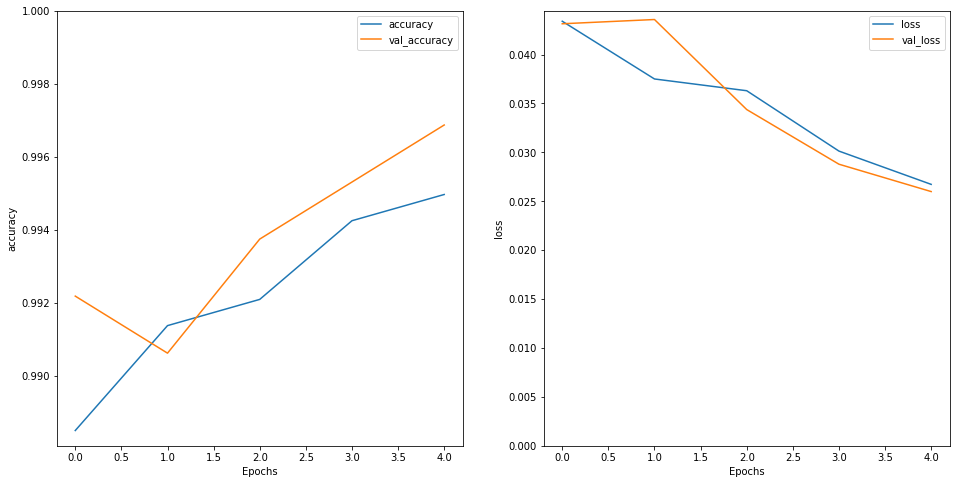

In [ ]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.04340615123510361, 0.037504274398088455, 0.03630252927541733, 0.030130673199892044, 0.026728902012109756]
[0.043148789554834366, 0.04358226805925369, 0.03437751531600952, 0.0287900622934103, 0.02599216438829899]
[0.9885057210922241, 0.9913793206214905, 0.9920976758003235, 0.9942528605461121, 0.9949712753295898]
[0.9921875, 0.9906250238418579, 0.9937499761581421, 0.995312511920929, 0.996874988079071]


In [ ]:
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 196ms/step
[[-5.228708]]
[-5.228708, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 196ms/step
[[-5.228708]]
1/1 [==============================] - 0s 209ms/step
[[0.8654758]]
1/1 [==============================] - 0s 195ms/step
[[-11.501907]]
1/1 [==============================] - 0s 213ms/step
[[1.4912754]]
1/1 [==============================] - 0s 198ms/step
[[3.992181]]
1/1 [==============================] - 0s 199ms/step
[[-10.339931]]
1/1 [==============================] - 0s 197ms/step
[[-11.143356]]
You passed the challenge. Great job!
